Based on https://www.nature.com/articles/s41598-018-35682-z

In [1]:
!pip install -U scikit-learn pandas xgboost bayesian-optimization

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.22.2.post1)
Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (1.0.3)
     |████████████████████████████████| 109.8MB 47kB/s 
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [0]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load data & Split

In [0]:
url = "https://static-content.springer.com/esm/art%3A10.1038%2Fs41598-018-35682-z/MediaObjects/41598_2018_35682_MOESM2_ESM.csv"
data = pd.read_csv(url)

In [0]:
from sklearn.model_selection import train_test_split
import numpy as np
X = data.iloc[:, 1:24]
y = data.MSI_Class
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

Training set by Project and MSI_Class

In [5]:
pd.crosstab(X_train.Project, y_train)

MSI_Class,0,1
Project,,
COAD,243,46
READ,95,3
STAD,270,64
UCEC,245,108


Testing set by Project and MSI_Class

In [6]:
pd.crosstab(X_test.Project, y_test)

MSI_Class,0,1
Project,,
COAD,67,21
READ,30,3
STAD,82,21
UCEC,91,43


In [7]:
X_train = X_train.drop('Project', 1)
X_test = X_test.drop('Project', 1)
list(map(np.shape, [X_train , X_test, y_train, y_test]))

[(1074, 22), (358, 22), (1074,), (358,)]

## MSIpred

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

MSIpred_pipe = Pipeline(steps=[
            ('normalizer', StandardScaler()),
            ('classifier', SVC(C=1000, gamma=0.001))
         ])

MSIpred_pipe.fit(X_test, y_test)

Pipeline(memory=None,
         steps=[('normalizer',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 SVC(C=1000, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=0.001,
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

## My Model

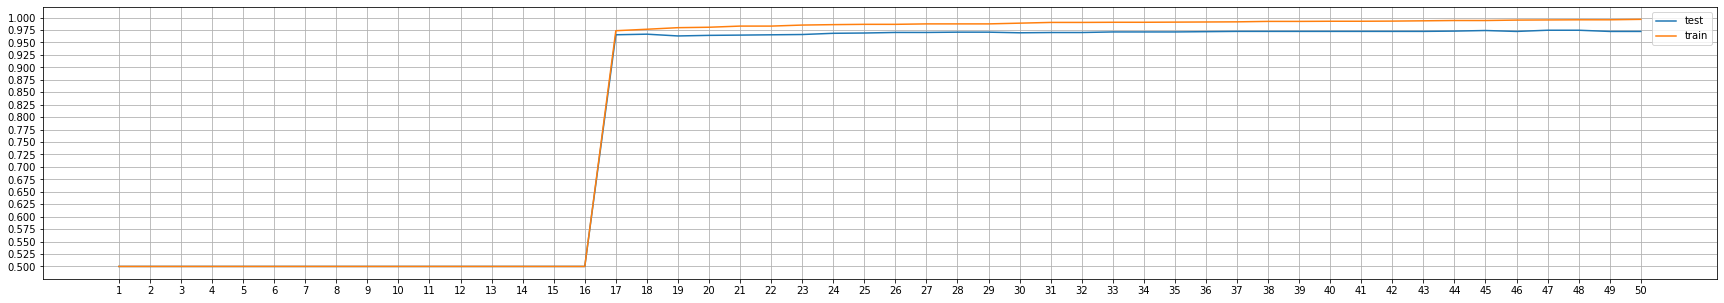

In [9]:
import xgboost as xgb
param = {'max_depth': 4, 'subsample': 0.8, 'eta': 0.03, 'objective':'binary:hinge' }
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

def xgb_cv(param, num_round=50):
  results = xgb.cv(param, dtrain, num_round, metrics='auc')
  results.index += 1
  plt.figure(figsize=(30, 5))
  plt.plot(results['test-auc-mean'], label="test")
  plt.plot(results['train-auc-mean'], label="train")
  plt.xticks(np.arange(1, num_round + 1, 1))
  plt.yticks(np.arange(0.5, 1.025, 0.025))
  plt.legend()
  plt.grid()
  plt.show()

xgb_cv(param)

ROC AUC: 0.9737047312386945


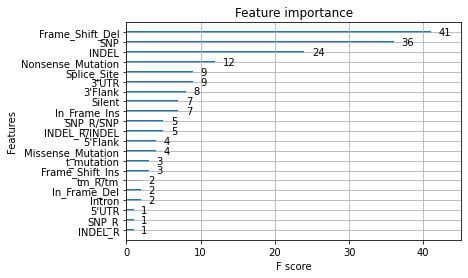

In [10]:
from sklearn.metrics import roc_auc_score
num_round = 18
clf = xgb.train(param, dtrain, num_round)
xgb.plot_importance(clf);
print("ROC AUC:", roc_auc_score(y_train, clf.predict(dtrain)))

Find optimum `max_depth`, `min_child_weight`, `gamma`

In [11]:
from bayes_opt import BayesianOptimization

def xgb_auc(**kwargs):
    params = {**param, **kwargs}
    params['max_depth'] = int(params['max_depth'])
    results = xgb.cv(params, dtrain, num_round, metrics='auc')
    return results.iloc[-1]['test-auc-mean']

hyperparameter_space = {
    'max_depth': (2, 15),
    'min_child_weight': (1, 5),
    'gamma': (0, 2)
}

optimizer = BayesianOptimization(f=xgb_auc,
                                 pbounds=hyperparameter_space,
                                 random_state=1,
                                 verbose=1)
optimizer.maximize(
    init_points=30,
    n_iter=200
)

optimizer.max

|   iter    |  target   |   gamma   | max_depth | min_ch... |
-------------------------------------------------------------
|  9        |  0.9666   |  1.753    |  13.63    |  1.34     |
|  31       |  0.9666   |  1.994    |  14.92    |  1.29     |


{'params': {'gamma': 1.9944890365406398,
  'max_depth': 14.920744068189983,
  'min_child_weight': 1.2895081499302625},
 'target': 0.966619}

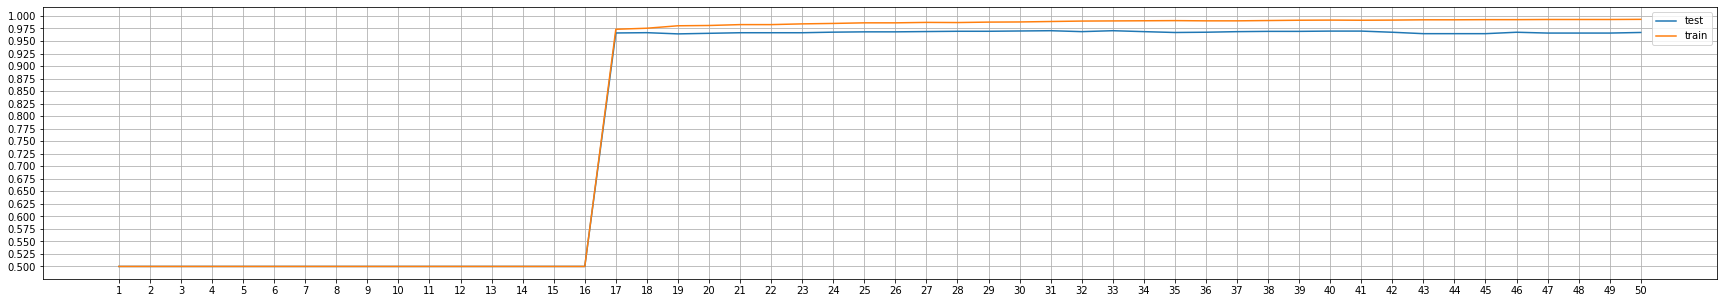

In [12]:
param = {
    **param,
    'max_depth': 14,
    'min_child_weight': 1.29,
    'gamma': 1.99
}
xgb_cv(param)

ROC AUC: 0.9760493971238058


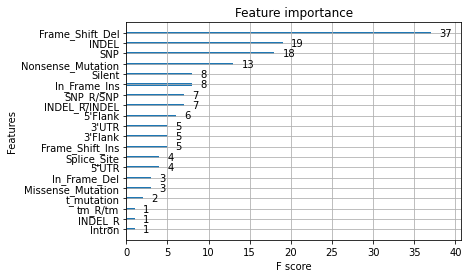

In [13]:
num_round = 18
clf = xgb.train(param, dtrain, num_round)
xgb.plot_importance(clf);
print("ROC AUC:", roc_auc_score(y_train, clf.predict(dtrain)))

Find optimum `subsample`, `colsample_bytree`, `alpha`

In [14]:
from bayes_opt import BayesianOptimization

hyperparameter_space = {
    'subsample': (0.6, 0.9),
    'colsample_bytree': (0.6, 0.9),
    'alpha': (0, 0.05)
}

optimizer = BayesianOptimization(f=xgb_auc,
                                 pbounds=hyperparameter_space,
                                 random_state=1,
                                 verbose=1)
optimizer.maximize(
    init_points=30,
    n_iter=200
)

optimizer.max

|   iter    |  target   |   alpha   | colsam... | subsample |
-------------------------------------------------------------
|  3        |  0.9622   |  0.009313 |  0.7037   |  0.719    |
|  4        |  0.9653   |  0.02694  |  0.7258   |  0.8056   |
|  5        |  0.9682   |  0.01022  |  0.8634   |  0.6082   |
|  11       |  0.9689   |  0.004917 |  0.7263   |  0.8874   |
|  14       |  0.9695   |  0.03751  |  0.8967   |  0.8244   |
|  31       |  0.9706   |  0.01205  |  0.8948   |  0.8942   |


{'params': {'alpha': 0.012048418543526352,
  'colsample_bytree': 0.8947540217237866,
  'subsample': 0.8941618430080702},
 'target': 0.970582}

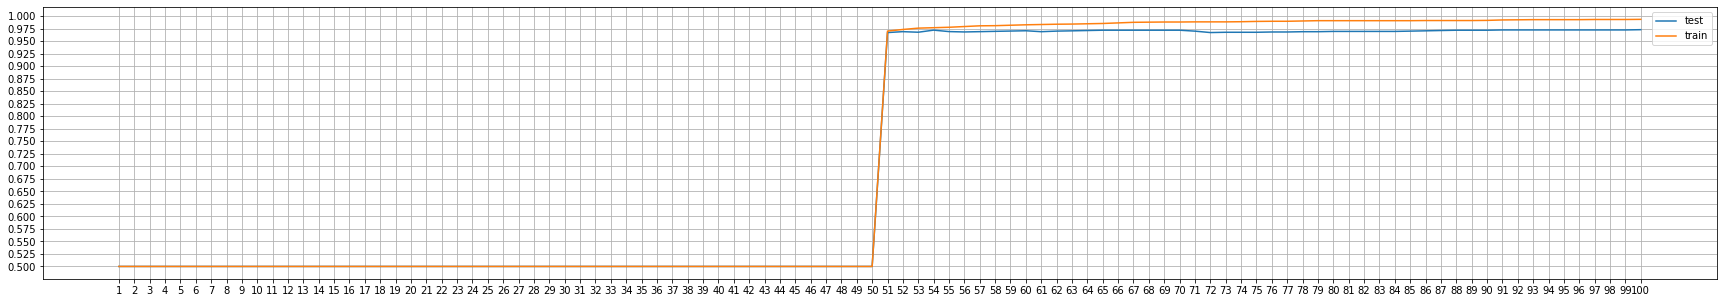

In [15]:
param = {
    **param,
    'subsample': 0.894,
    'colsample_bytree': 0.895,
    'alpha': 0.012,
    'eta': 0.01
}
xgb_cv(param, 100)

ROC AUC: 0.9742908977099722


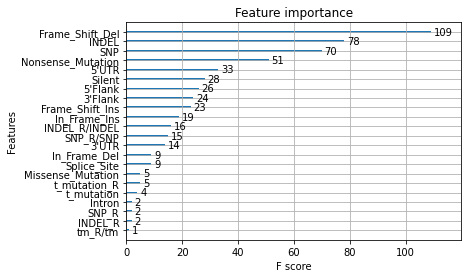

In [16]:
num_round = 54
clf = xgb.train(param, dtrain, num_round)
xgb.plot_importance(clf);
print("ROC AUC:", roc_auc_score(y_train, clf.predict(dtrain)))

## Testing

In [17]:
display(HTML('<h2>MSIpred</h2>'))
print(classification_report(y_test, MSIpred_pipe.predict(X_test), digits=4))
display(HTML('<h2>My model</h2>'))
print(classification_report(y_test, clf.predict(dtest), digits=4))

              precision    recall  f1-score   support

           0     0.9890    1.0000    0.9945       270
           1     1.0000    0.9659    0.9827        88

    accuracy                         0.9916       358
   macro avg     0.9945    0.9830    0.9886       358
weighted avg     0.9917    0.9916    0.9916       358



              precision    recall  f1-score   support

           0     0.9921    0.9333    0.9618       270
           1     0.8269    0.9773    0.8958        88

    accuracy                         0.9441       358
   macro avg     0.9095    0.9553    0.9288       358
weighted avg     0.9515    0.9441    0.9456       358



## Non-TCGA testing

In [0]:
url_non_tcga = "https://static-content.springer.com/esm/art%3A10.1038%2Fs41598-018-35682-z/MediaObjects/41598_2018_35682_MOESM3_ESM.csv"
data_non_tcga = pd.read_csv(url_non_tcga)
data_non_tcga['MSI_Class'] = data_non_tcga['MSI_STATUS'].map({'MSS': 0, 'MSI-H': 1})
X_non_tcga = data_non_tcga.iloc[:, 1:23].fillna(0)
y_non_tcga = data_non_tcga.MSI_Class
dtest_non_tcga = xgb.DMatrix(X_non_tcga)

In [19]:
display(HTML('<h2>MSIpred</h2>'))
print(classification_report(y_non_tcga, MSIpred_pipe.predict(X_non_tcga), digits=4))
display(HTML('<h2>My model</h2>'))
print(classification_report(y_non_tcga, clf.predict(dtest_non_tcga), digits=4))

              precision    recall  f1-score   support

           0     0.9369    0.9900    0.9627       300
           1     0.9589    0.7778    0.8589        90

    accuracy                         0.9410       390
   macro avg     0.9479    0.8839    0.9108       390
weighted avg     0.9420    0.9410    0.9388       390



              precision    recall  f1-score   support

           0     0.9767    0.9767    0.9767       300
           1     0.9222    0.9222    0.9222        90

    accuracy                         0.9641       390
   macro avg     0.9494    0.9494    0.9494       390
weighted avg     0.9641    0.9641    0.9641       390

